In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import zipfile
drive_zip = '/content/drive/My Drive/rockpaperscissorss.zip'
zip_ref = zipfile.ZipFile(drive_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from tqdm.notebook import tqdm as tq
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from matplotlib import pyplot as plt
from keras.preprocessing import image

In [ ]:
base_dir = '/content/rockpaperscissorss'
tag = []
file_name = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({'tag':tag, 'file_name':file_name, 'path':full_path})
df.groupby(['tag']).size()

tag
paper                 1424
rock                  1452
rockpaperscissorss       1
scissors              1501
dtype: int64

In [ ]:
df.head()

,tag,file_name,path
0,rockpaperscissorss,.DS_Store,/content/rockpaperscissorss/.DS_Store
1,paper,4dpYSXpjYbiH9MSq.png,/content/rockpaperscissorss/paper/4dpYSXpjYbiH...
2,paper,rffdDFsMVDDkn32c.png,/content/rockpaperscissorss/paper/rffdDFsMVDDk...
3,paper,JRZTPL2YQ6cfIMh9 copy.png,/content/rockpaperscissorss/paper/JRZTPL2YQ6cf...
4,paper,5kJec3v9txvrAb4g copy.png,/content/rockpaperscissorss/paper/5kJec3v9txvr...


In [ ]:
df.drop(0, axis=0, inplace=True)

In [ ]:
df.head()

,tag,file_name,path
1,paper,4dpYSXpjYbiH9MSq.png,/content/rockpaperscissorss/paper/4dpYSXpjYbiH...
2,paper,rffdDFsMVDDkn32c.png,/content/rockpaperscissorss/paper/rffdDFsMVDDk...
3,paper,JRZTPL2YQ6cfIMh9 copy.png,/content/rockpaperscissorss/paper/JRZTPL2YQ6cf...
4,paper,5kJec3v9txvrAb4g copy.png,/content/rockpaperscissorss/paper/5kJec3v9txvr...
5,paper,fYuJzeeHPzGwlGh0 copy.png,/content/rockpaperscissorss/paper/fYuJzeeHPzGw...


In [ ]:
# Split dataset menjadi training dataset dan validation dataset

X = df['path']
y = df['tag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=300)

In [ ]:
# Dikelompokkan ke dalam subdirectory training dataset dan validation dataset

train_dir = pd.DataFrame({
    'set':'train',
    'tag':y_train,
    'path':X_train})

val_dir = pd.DataFrame({
    'set':'validation',
    'tag':y_val,
    'path':X_val})

In [ ]:
train_dir.head(3)

,set,tag,path
2968,train,rock,/content/rockpaperscissorss/rock/N235Vnlue0M9S...
2321,train,scissors,/content/rockpaperscissorss/scissors/uCRRTGuvP...
2043,train,scissors,/content/rockpaperscissorss/scissors/3Q6h5cXYe...


In [ ]:
val_dir.head(3)

,set,tag,path
651,validation,paper,/content/rockpaperscissorss/paper/9yGlnLxGtzq1...
3050,validation,rock,/content/rockpaperscissorss/rock/yQIWMi6PpMKRM...
4056,validation,rock,/content/rockpaperscissorss/rock/ELmZ4ELVncvjq...


In [ ]:
print('Jumlah data train:', len(train_dir))
print('Jumlah data validation:', len(val_dir))

Jumlah data train: 3501
Jumlah data validation: 876


In [ ]:
# Jumlah data tiap directory

subdirectory_ttv = train_dir.append(val_dir).reset_index(drop=1)
print(subdirectory_ttv.groupby(['set','tag']).size())

set         tag     
train       paper       1147
            rock        1173
            scissors    1181
validation  paper        277
            rock         279
            scissors     320
dtype: int64


Membuat Folder Train dan Validation yang akan digunakan sebagai data training

In [ ]:
datasource_ttv = '/content/rockpaperscissorss'
dataset_ttv = 'fix_dataset/'

for index, row in tq(subdirectory_ttv.iterrows()):

    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_ttv,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_ttv,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_ttv,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_ttv,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

Menggunakan objek Image Data Generator sebelumnya untuk mempersiapkan data latih yang akan dipelajari oleh model.

In [ ]:
training_generator = training_datagen.flow_from_directory(
    '/content/fix_dataset/train',
    target_size=(150, 150),
    batch_size=15,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb')

val_generator = validation_datagen.flow_from_directory(
    '/content/fix_dataset/validation',
    target_size=(150, 150),
    batch_size=15,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb')

num_class = val_generator.num_classes
labels = training_generator.class_indices.keys()

Found 3501 images belonging to 3 classes.
Found 875 images belonging to 3 classes.


In [ ]:
print(labels)

dict_keys(['paper', 'rock', 'scissors'])


Membuat Arsitektur CNN

In [ ]:
model = Sequential()

# Convolutional layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(56, 56, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 4 hidden layer
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compile Model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training Model

model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    shuffle=True)

Epoch 1/10
234/234 [==============================] - 18s 77ms/step - loss: 1.0936 - accuracy: 0.3639 - val_loss: 0.9462 - val_accuracy: 0.4869
Epoch 2/10
234/234 [==============================] - 17s 73ms/step - loss: 0.8310 - accuracy: 0.5704 - val_loss: 0.5234 - val_accuracy: 0.6663
Epoch 3/10
234/234 [==============================] - 17s 74ms/step - loss: 0.7055 - accuracy: 0.6304 - val_loss: 0.2525 - val_accuracy: 0.6651
Epoch 4/10
234/234 [==============================] - 17s 73ms/step - loss: 0.5878 - accuracy: 0.7069 - val_loss: 0.7605 - val_accuracy: 0.8046
Epoch 5/10
234/234 [==============================] - 17s 74ms/step - loss: 0.5632 - accuracy: 0.7435 - val_loss: 0.2811 - val_accuracy: 0.8537
Epoch 6/10
234/234 [==============================] - 17s 73ms/step - loss: 0.4961 - accuracy: 0.7995 - val_loss: 0.4309 - val_accuracy: 0.8903
Epoch 7/10
234/234 [==============================] - 17s 73ms/step - loss: 0.4624 - accuracy: 0.8440 - val_loss: 0.4062 - val_accuracy:

Prediksi Model

In [ ]:
import requests
from tensorflow.keras.models import load_model
from io import BytesIO
from PIL import Image
from google.colab import files

In [ ]:
input_size = (56, 56)
channel = (3,)
input_shape = input_size + channel
labels = ['paper','rock','scissor']

In [ ]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [ ]:
im = Image.open('/content/fix_dataset/validation/paper/0Uomd0HvOB33m47I.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

paper 0.9677926


In [ ]:
im = Image.open('/content/fix_dataset/validation/rock/1BqjHe5igJAgUjiN copy.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

rock 0.99966264


In [ ]:
im = Image.open('/content/fix_dataset/validation/scissors/1i1dlQrE6JnhYXE4.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

scissor 0.99979717


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Saving 1Frbe8cdOdkciOBg.png to 1Frbe8cdOdkciOBg (1).png
1Frbe8cdOdkciOBg.png
paper


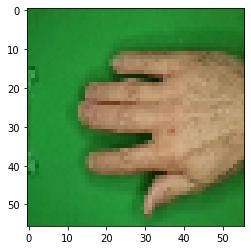

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(56,56))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')

Saving 2E8j595xseKRF60J.png to 2E8j595xseKRF60J.png
2E8j595xseKRF60J.png
scissors


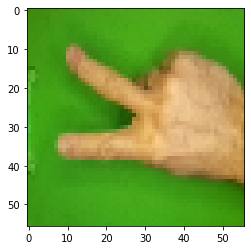

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(56,56))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')

Saving 1BqjHe5igJAgUjiN.png to 1BqjHe5igJAgUjiN.png
1BqjHe5igJAgUjiN.png
rock


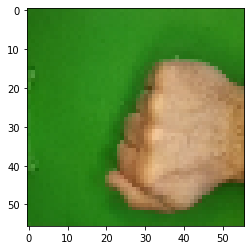

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(56,56))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')